In [2]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import imageio as io
H, W = 512, 1024


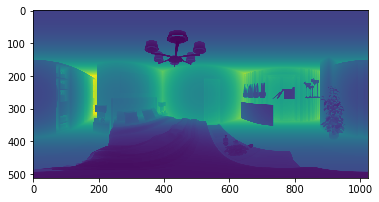

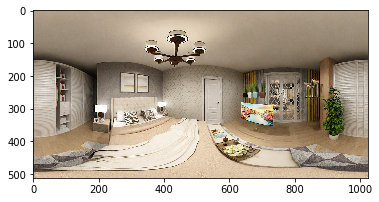

In [3]:
name = '03122_554516'
baseDir = './data/'

rgb = np.array(Image.open('./data/scene_03122_554516_rgb.png'))
d = np.array(Image.open('./data/scene_03122_554516_depth.png'))

d_max = np.max(d)
d = d / d_max

plt.imshow(d)
plt.show()

plt.imshow(rgb)
plt.show()

# Fill empty depth by interpolating neighbors (optional)
Some depth map in the dataset might be empty, for small regions, we fill them with neighbor values.

In [13]:
idx_0, idx_1 = np.where(d==0)
idx_0, idx_1 = idx_0[ 420 > idx_0], idx_1[ 420 > idx_0] 
idx_0, idx_1 = idx_0[idx_0 > 80], idx_1[ idx_0 > 80] 

d_fill = np.zeros(d.shape)

d_fill[idx_0, idx_1] = 1

from itertools import groupby
from operator import itemgetter


for i in range(512):
    y_idx = np.where(d_fill[i]>0)[0]
    
    if len(y_idx)==0: continue
    if len(y_idx) == 1:
        d_fill[i, y_idx[0]] = (d[i, y_idx[0]-1] + d[i, y_idx[0]+1]) / 2
        continue
    interval = []
    
    gaps = [[s, e] for s, e in zip(y_idx, y_idx[1:]) if s+1 < e]
    edges = np.concatenate([y_idx[:1], np.array(sum(gaps, [])), y_idx[-1:]])
    
    interval = [[int(s), int(e)+1] for s, e in zip(edges[::2], edges[1:][::2])]
    if interval[0][0] == 0:
        interval[0][0] = interval[-1][0] - 1024
        interval = interval[:-1]

    for s, e in interval:
        if s < 0:
            interp = np.linspace(d[i, s-1], d[i, e+1], e-s)
            d_fill[i, s:] = interp[:-s]
            d_fill[i, :e] = interp[-s:]
        else:
            d_fill[i, s:e] = np.linspace(d[i, s-1], d[i, e+1], e-s)
plt.imshow(d)
plt.show()
plt.imshow(d_fill+d)
plt.show()

d = d + d_fill

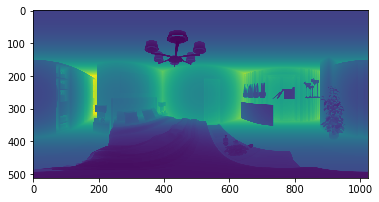

In [14]:
original_d = d * d_max
plt.imshow(original_d)
plt.show()

In [9]:
def translate(crd, rgb, d, cam=[]):
    H, W = rgb.shape[0], rgb.shape[1]
    d = np.where(d==0, -1, d)
    
    # move coordinates and calculate new depth
    tmp_coord = crd - cam
    new_d = np.sqrt(np.sum(np.square(tmp_coord), axis=2))
    
    
    # normalize: /depth
    new_coord = tmp_coord / new_d.reshape(H,W,1)
    new_depth = np.zeros(new_d.shape)
    img = np.zeros(rgb.shape)

    
    # backward: 3d coordinate to pano image
    [x, y, z] = new_coord[..., 0], new_coord[..., 1], new_coord[..., 2]
    

    idx = np.where(new_d>0)
    
    # theta: horizontal angle, phi: vertical angle
    theta = np.zeros(y.shape)
    phi = np.zeros(y.shape)
    x1 = np.zeros(z.shape)
    y1 = np.zeros(z.shape)

    theta[idx] = np.arctan2(y[idx], np.sqrt(np.square(x[idx]) + np.square(z[idx])))
    phi[idx] = np.arctan2(-z[idx], x[idx])
    
    x1[idx] = (0.5 - theta[idx] / np.pi) * H #- 0.5  # (1 - np.sin(theta[idx]))*H/2 - 0.5
    y1[idx] = (0.5 - phi[idx]/(2*np.pi))*W #- 0.5
    x, y = np.floor(x1).astype('int'), np.floor(y1).astype('int')
    
    img = np.zeros(rgb.shape)
    # Mask out
    mask = (new_d > 0) & (H > x) & (x > 0) & (W > y) & (y > 0)
    x = x[mask]
    y = y[mask]
    new_d = new_d[mask]
    rgb = rgb[mask]
    # Give smaller depth pixel higher priority
    reorder = np.argsort(-new_d)
    x = x[reorder]
    y = y[reorder]
    new_d = new_d[reorder]
    rgb = rgb[reorder]
    # Assign
    new_depth[x, y] = new_d
    img[x, y] = rgb
                

    depth_margin = 4
    for i in range(depth_margin, H, 2):
        for j in range(depth_margin, W, 2):

            x_l = max(0, i-depth_margin)
            x_r = min(H, i+depth_margin)
            y_l, y_r = max(0, j-depth_margin), min(W, j+depth_margin)
            
            index = np.where(new_depth[x_l:x_r, y_l:y_r]>0)
            if len(index[0]) == 0: continue 
            mean = np.median(new_depth[x_l:x_r, y_l:y_r][index]) # median
            target_index = np.where(new_depth[x_l:x_r, y_l:y_r] > mean*1.3)
            
            if len(target_index[0]) > depth_margin ** 2 // 2:
                # reduce block size
                img[x_l:x_r, y_l:y_r][target_index] = 0#np.array([255.0, 0.0, 0.0])
                new_depth[x_l:x_r, y_l:y_r][target_index] = 0
    
    
    mask = (new_depth != 0).astype(int)

    return img, new_depth.reshape(H,W,1), tmp_coord, cam.reshape(1, 1, 3), mask

# Augment single source image to 100 samples

In [15]:
# test camera pose
if not os.path.exists(baseDir): os.mkdir(baseDir)
if not os.path.exists(os.path.join(baseDir, 'rm_occluded')): os.mkdir(os.path.join(baseDir, 'rm_occluded'))
if not os.path.exists(os.path.join(baseDir, 'test')): os.mkdir(os.path.join(baseDir, 'test'))
io.imsave(os.path.join(baseDir, name + '_rgb.png'), rgb)
if baseDir.split('/')[-2] == 'mp3d':
    io.imsave(os.path.join(baseDir, name + '_depth.exr'), np.float32(original_d))
    print(os.path.join(baseDir, name + '_depth.exr'))
else:
    Image.fromarray(np.uint8(d*255)).save(os.path.join(baseDir, name + '_d.png'))


0.33006648608717065 -0.20625461708938683
0.3310743249810641 -0.20685615760886936
Num  100


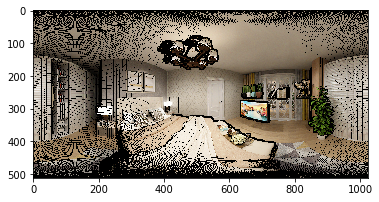

Num  101


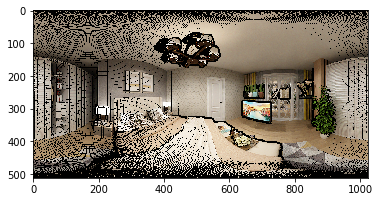

Num  102


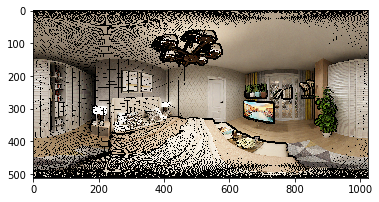

Num  103


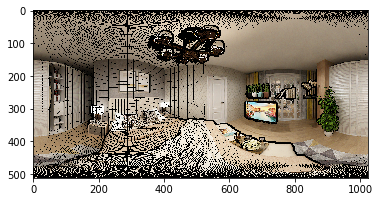

Num  104


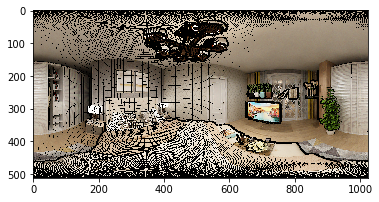

Num  105


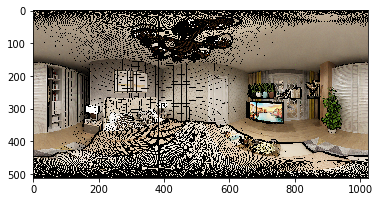

Num  106


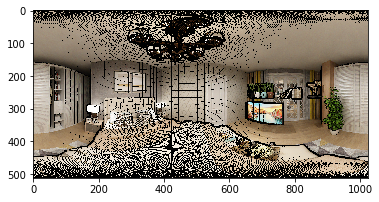

Num  107


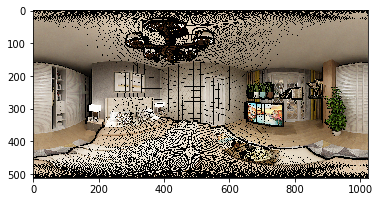

Num  108


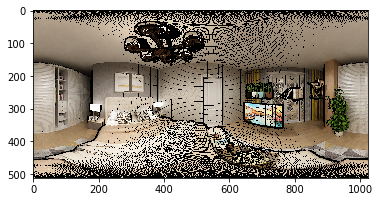

Num  109


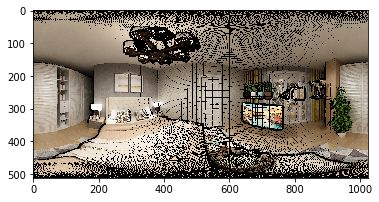

Num  110


/home/jessie/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


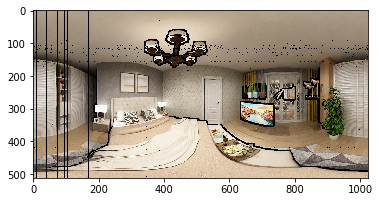

In [18]:
# normalize to [0, 1]
d = d.reshape(rgb.shape[0], rgb.shape[1], 1) / np.max(d)
d = np.where(d==0, 1, d)


H, W = 512, 1024
_y = np.repeat(np.array(range(W)).reshape(1,W), H, axis=0)
_x = np.repeat(np.array(range(H)).reshape(1,H), W, axis=0).T


_theta = (1 - 2 * (_x) / H) * np.pi/2 # latitude
_phi = 2*np.pi*(0.5 - (_y)/W ) # longtitude

axis0 = (np.cos(_theta)*np.cos(_phi)).reshape(H, W, 1)
axis1 = np.sin(_theta).reshape(H, W, 1)
axis2 = (-np.cos(_theta)*np.sin(_phi)).reshape(H, W, 1)
coord = np.concatenate((axis0, axis1, axis2), axis=2)*d

scale = 0.6
cam_pos = []

################ XZ ONLY ################
max_, min_ = coord[256, 512, 0]*scale, coord[256, 0, 0]*scale

pos_ = np.stack([np.linspace(max_, min_, 50), np.zeros(50), np.zeros(50)], axis=1)
cam_pos.append(pos_)
print(max_, min_)
# Z
max_, min_ = coord[256, 640, 2]*scale, coord[256, 128, 2]*scale
pos_ = np.stack([np.zeros(50), np.zeros(50), np.linspace(max_, min_, 50)], axis=1)
cam_pos.append(pos_)
print(max_, min_)
################ XY ONLY ################

cam_pos = np.concatenate(cam_pos, axis=0)
# save training, testnig camera poses
with open(os.path.join(baseDir, 'cam_pos.txt'), 'w') as fp:
    for p in cam_pos: fp.write('%f %f %f\n' % (p[0], p[1], p[2])) 

test_pos = np.array([[-0.05,      0.,       -0.05    ],
                    [-0.03,      0.,       -0.05    ],
                    [-0.01,      0.,       -0.05    ],
                    [ 0.01,      0.,       -0.05    ],
                    [ 0.03,      0.,       -0.05    ],
                    [ 0.05,      0.,       -0.05    ],
                    [ 0.05,      0.,       -0.03    ],
                    [ 0.05,      0.,       -0.01    ],
                    [ 0.05,      0.,        0.01    ],
                    [ 0.05,      0.,        0.03    ]])

with open(os.path.join(baseDir, 'test', 'cam_pos.txt'), 'w') as fp:
    for p in test_pos: fp.write('%f %f %f\n' % (p[0], p[1], p[2])) 

cam_pos = np.concatenate([cam_pos, test_pos, np.array([0.0, 0.0, 0.0]).reshape(1,3)])


images = []
depth = []
for n, cam in enumerate(cam_pos):
    if n<100: continue
    img = rgb.copy()
    print("Num ", n)
    tmp_coord = np.concatenate((axis0, axis1, axis2), axis=2)
    img1, d1, _, _, mask1 = translate(coord, rgb, d, cam)
    img2, d2, _, _, mask2 = translate(tmp_coord*d1, img1, d1, -cam)
    
    
    plt.imshow(np.uint8(img1))
    plt.show()
    
    if n < 100:
        Image.fromarray(np.uint8(mask2*255)).save(os.path.join(baseDir, 'rm_occluded', 'mask_%d.png' % n))
    elif n < 111:
        if not os.path.exists('test'):
            os.makedirs('test')
        Image.fromarray(np.uint8(img1)).save(os.path.join(baseDir, 'test', 'rgb_%d.png' % (n-100)))
    images.append(img)
